# Event-based Visual Microphone

### Purpose
This notebook is designed to extract audible sounds from a video of an object vibrating in response to those sounds. The process begins with the transformation of a standard RGB video into an event video. This step is necessary because an event camera was not available at the time of this project. Following the transformation, the event video is then processed to recover sound.

### Objectives
- To break a RGB video into segments.
- To convert the RGB videos to event videos, using a v2e toolbox inspired simulator.
- To convert the event videos to sound using Abe Davis' Visual Microphone method.
- To use a bandwidth extension model to enhance the recovered sound.
- To visualise the recovered signal.

### Dependencies
To run this notebook, you will need the following libraries:
- `cv2`: OpenCV
- `numpy` : NumPy
- `scipy` : SciPy
- `torch` : PyTorch
- `librosa` : Librosa
- `tensorflow` : TensorFlow
- `matplotlib` : Matplotlib
- `soundfile` : Soundfile
- `sounddevice` : Sounddevice

In [1]:
import utilities.video_frames as frames
import event_camera.simulator_utils as camera
import steerable_pyramid.davis_method as pyramid

## Break RGB video into segments
The code bellow assess the video size and breaks it into 2GB segments. The videos are stored in a tempory folder in Documents, which is then deleted automatically at the end.

<span style="color:red"> Enter the input video file path and fps bellow: </span>

In [2]:
framerate = 20000
video_path = '/Volumes/Omkar 5T/video_dataset/chips3.avi'

In [3]:
frames.extract_video_segments(video_path)

KeyboardInterrupt: 

## Convert RGB video to event video
This process uses a v2e toolbox inspired model created by Tobi Delbruck, Yuhuang Hu and Zhe He. The only difference is that our model doesn't include event noise. There are two important variables:
- **Cut-off frequency** (`cutoff_freq`): for event pixel bandwidth: more information can be extracted at lower frequencies. This makes it perfect for low light conditions.
- **+/-ve thresholds** (`pos_thresh` and `neg_thresh`) : completely based on cut-off frequency and the maximum allowable events for any pixel.

### Ideal paramters for Visual Microphone dataset
For the slow-motion RGB videos from Abe Davis' Visual Microphone dataset, the ideal parameters are:
- MIDI Chips Bag: `3e-4` cutoff-freq, `8e-7` pos_thresh and `8e-7` neg_thresh
- MIDI Plants: `3e-5` cutoff-freq, `9e-8` pos_thresh and `9e-8` neg_thresh
- Speech Chips Bag 2.2kHz: `3e-4` cutoff-freq, `7e-7` pos_thresh and `7e-7` neg_thresh
- Speech Chips Bag 20kHz: `3e-6` cutoff-freq, `7e-10` pos_thresh and `7e-10` neg_thresh

<span style="color:red"> Enter the simulation parameters bellow: </span>

In [ ]:
cutoff_freq = 3e-6
pos_thresh = 7e-10
neg_thresh = 7e-10

In [ ]:
video_fps = 30
sampling_period = 1/video_fps
camera.event_simulator(sampling_period, cutoff_freq, pos_thresh, neg_thresh)

Temporary folder created: /Users/omkarpatil/Documents/TemporaryEventVideoSegments
Converted and saved video segment 1/18 to Documents.
Converted and saved video segment 2/18 to Documents.
Converted and saved video segment 3/18 to Documents.
Converted and saved video segment 4/18 to Documents.
Converted and saved video segment 5/18 to Documents.
Converted and saved video segment 6/18 to Documents.
Converted and saved video segment 7/18 to Documents.
Converted and saved video segment 8/18 to Documents.
Converted and saved video segment 9/18 to Documents.
Converted and saved video segment 10/18 to Documents.
Converted and saved video segment 11/18 to Documents.
Converted and saved video segment 12/18 to Documents.
Converted and saved video segment 13/18 to Documents.
Converted and saved video segment 14/18 to Documents.
Converted and saved video segment 15/18 to Documents.
Converted and saved video segment 16/18 to Documents.
Converted and saved video segment 17/18 to Documents.
Converted

The code bellow allows to see the event video after conversion.

In [ ]:
#camera.show_video()

2024-06-24 12:37:07.457 Python[25209:478593] WARNING: Secure coding is automatically enabled for restorable state! However, not on all supported macOS versions of this application. Opt-in to secure coding explicitly by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState:.


KeyboardInterrupt: 

## Convert event video to sound

This step uses a phase-based method. The method applies a steerable pyramid to get a phase response at several scales and orientations. Then several steps are applied to flatten and average the response to a time-series signal. The important parameters for this process are:
- **Number of Scales** (`nscales`): defines the number of levels of the pyramid. For visual microphone this was set to 2.
- **Number of Orientations** (`norientations`): defines the number of steerable filters at a level of the pyramid. For visual microphone this was set to 4.

<span style="color:red"> Enter the steerable pyramid parameters and recovered sound file path bellow: </span>

In [4]:
nscales = 2
norientations = 4
save_path = '/Volumes/Omkar 5T/chips3.wav'

This step takes several hours, traditionally 2hrs.

Temporary folder created: /Users/omkarpatil/Documents/TemporarySoundSegments
Progress: 0.005150126178091363% done after 0.02533698081970215 seconds.


/Users/omkarpatil/Documents/event_based_visual_microphone/steerable_pyramid/davis_method.py:67: ComplexWarning: Casting complex values to real discards the imaginary part
  bands[:, (b-1)] = band.flatten()


Progress: 1.004274604727816% done after 4.806659936904907 seconds.
Progress: 2.0033990832775403% done after 9.5767240524292 seconds.
Progress: 3.0025235618272648% done after 14.303532123565674 seconds.
Progress: 4.001648040376989% done after 18.979583024978638 seconds.
Progress: 5.000772518926714% done after 23.63565707206726 seconds.
Progress: 5.999896997476438% done after 28.291596174240112 seconds.
Progress: 6.999021476026162% done after 32.85111403465271 seconds.
Progress: 7.998145954575888% done after 37.410463094711304 seconds.
Progress: 8.997270433125612% done after 41.95931816101074 seconds.
Progress: 9.996394911675337% done after 46.54686903953552 seconds.
Progress: 10.99551939022506% done after 51.15399503707886 seconds.
Progress: 11.994643868774785% done after 55.99985480308533 seconds.
Progress: 12.993768347324512% done after 60.711993932724 seconds.
Progress: 13.992892825874234% done after 65.37583184242249 seconds.
Progress: 14.992017304423957% done after 70.1641159057617

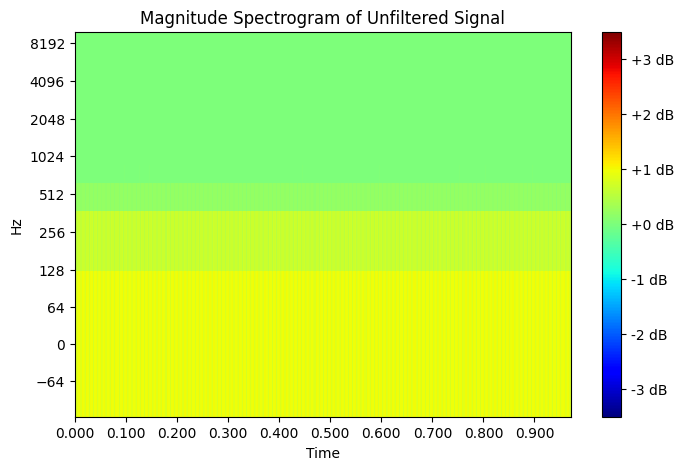

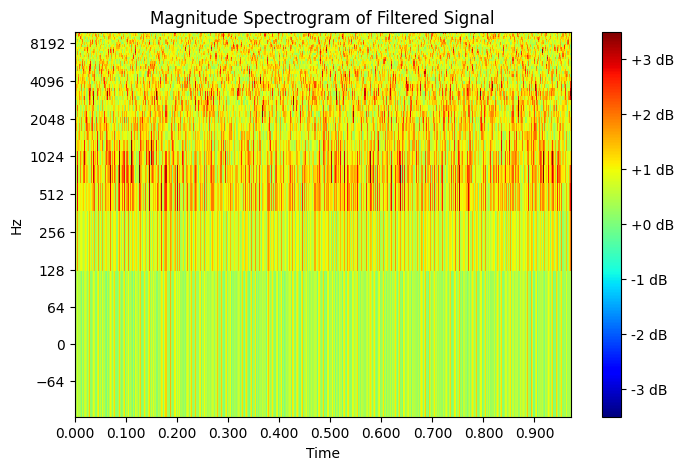

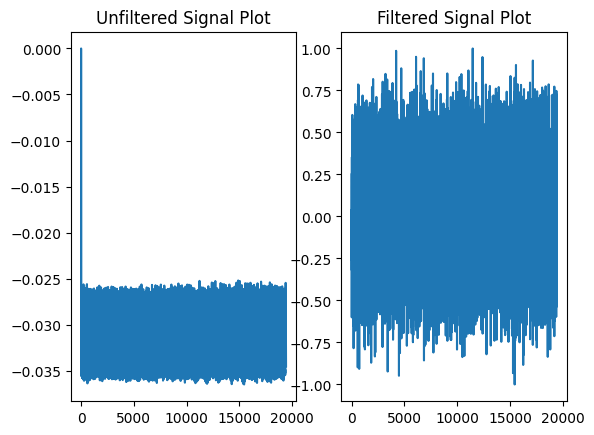

Converted and saved audio segment 1/18 to Documents.


/Users/omkarpatil/Documents/event_based_visual_microphone/steerable_pyramid/davis_method.py:67: ComplexWarning: Casting complex values to real discards the imaginary part
  bands[:, (b-1)] = band.flatten()


Progress: 0.005150126178091363% done after 0.025222301483154297 seconds.
Progress: 1.004274604727816% done after 5.188459157943726 seconds.
Progress: 2.0033990832775403% done after 9.81869626045227 seconds.
Progress: 3.0025235618272648% done after 14.404621124267578 seconds.
Progress: 4.001648040376989% done after 19.04645323753357 seconds.
Progress: 5.000772518926714% done after 23.634719371795654 seconds.
Progress: 5.999896997476438% done after 28.382476091384888 seconds.
Progress: 6.999021476026162% done after 33.02597117424011 seconds.
Progress: 7.998145954575888% done after 37.73894500732422 seconds.
Progress: 8.997270433125612% done after 42.34584903717041 seconds.
Progress: 9.996394911675337% done after 46.958719968795776 seconds.
Progress: 10.99551939022506% done after 51.647096157073975 seconds.
Progress: 11.994643868774785% done after 56.33316922187805 seconds.
Progress: 12.993768347324512% done after 60.90629029273987 seconds.
Progress: 13.992892825874234% done after 65.4152

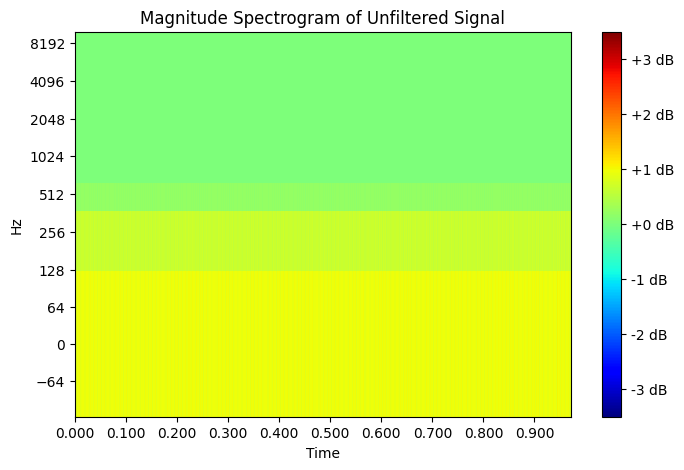

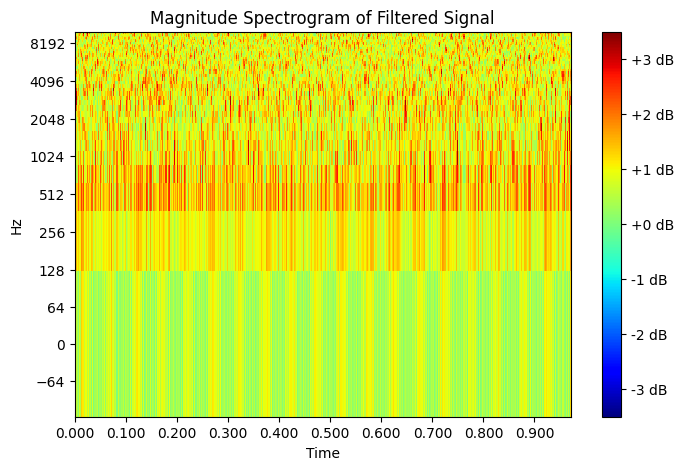

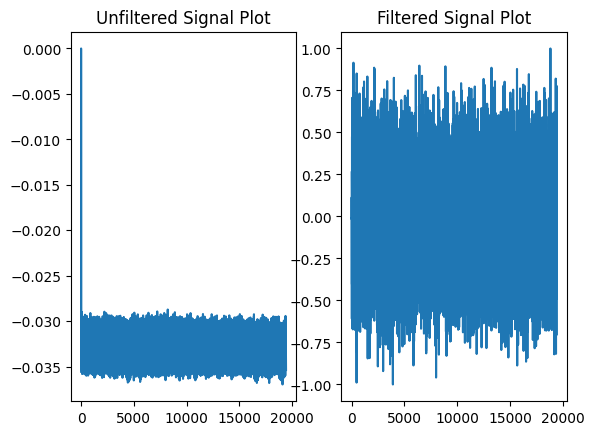

Converted and saved audio segment 2/18 to Documents.
Progress: 0.005150126178091363% done after 0.01888275146484375 seconds.
Progress: 1.004274604727816% done after 4.458118915557861 seconds.
Progress: 2.0033990832775403% done after 8.860440015792847 seconds.
Progress: 3.0025235618272648% done after 13.301649808883667 seconds.
Progress: 4.001648040376989% done after 17.870421886444092 seconds.
Progress: 5.000772518926714% done after 22.457101106643677 seconds.
Progress: 5.999896997476438% done after 26.84115195274353 seconds.
Progress: 6.999021476026162% done after 31.36935782432556 seconds.
Progress: 7.998145954575888% done after 35.81940293312073 seconds.
Progress: 8.997270433125612% done after 40.22590374946594 seconds.
Progress: 9.996394911675337% done after 44.78374195098877 seconds.
Progress: 10.99551939022506% done after 49.11103796958923 seconds.
Progress: 11.994643868774785% done after 53.47004795074463 seconds.
Progress: 12.993768347324512% done after 58.02651786804199 second

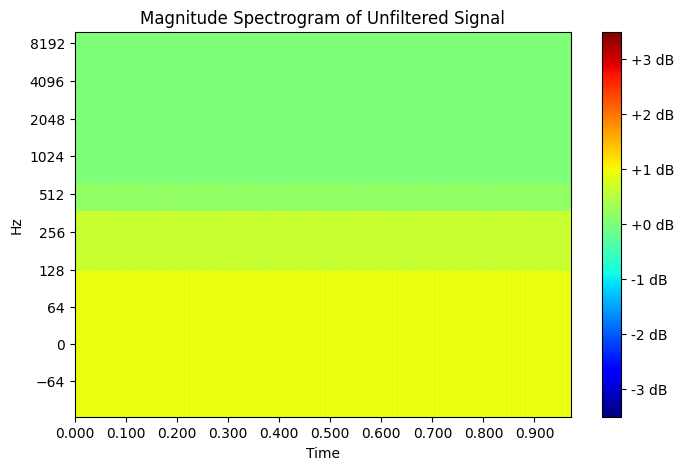

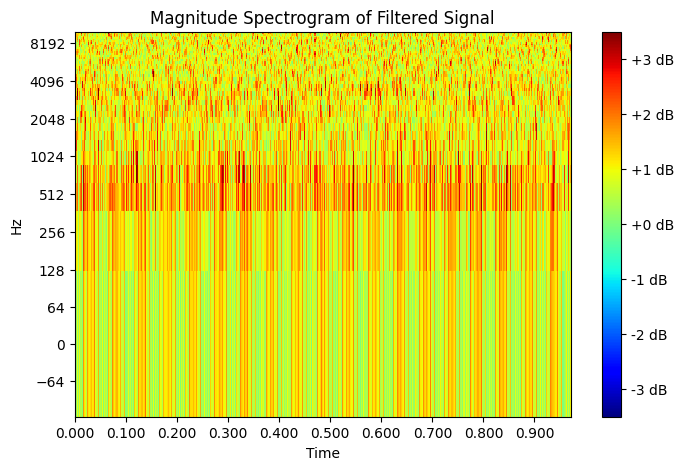

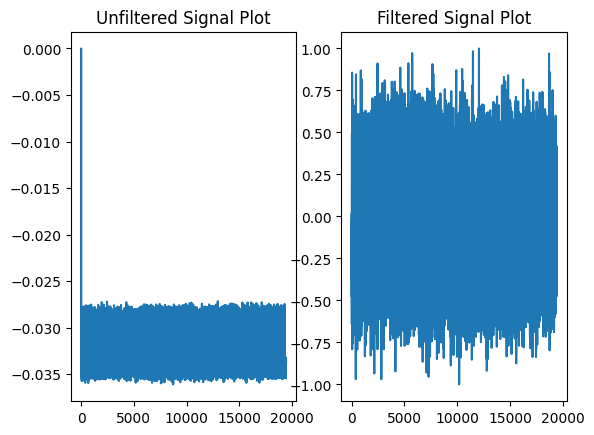

Converted and saved audio segment 3/18 to Documents.
Progress: 0.005150126178091363% done after 0.01996612548828125 seconds.
Progress: 1.004274604727816% done after 4.305743217468262 seconds.
Progress: 2.0033990832775403% done after 8.614199161529541 seconds.
Progress: 3.0025235618272648% done after 12.950672149658203 seconds.
Progress: 4.001648040376989% done after 17.443515062332153 seconds.
Progress: 5.000772518926714% done after 21.787360191345215 seconds.
Progress: 5.999896997476438% done after 26.215123176574707 seconds.
Progress: 6.999021476026162% done after 30.7627432346344 seconds.
Progress: 7.998145954575888% done after 35.29559922218323 seconds.
Progress: 8.997270433125612% done after 40.03039216995239 seconds.
Progress: 9.996394911675337% done after 44.77373719215393 seconds.
Progress: 10.99551939022506% done after 49.357216119766235 seconds.
Progress: 11.994643868774785% done after 53.811760902404785 seconds.
Progress: 12.993768347324512% done after 58.338623046875 second

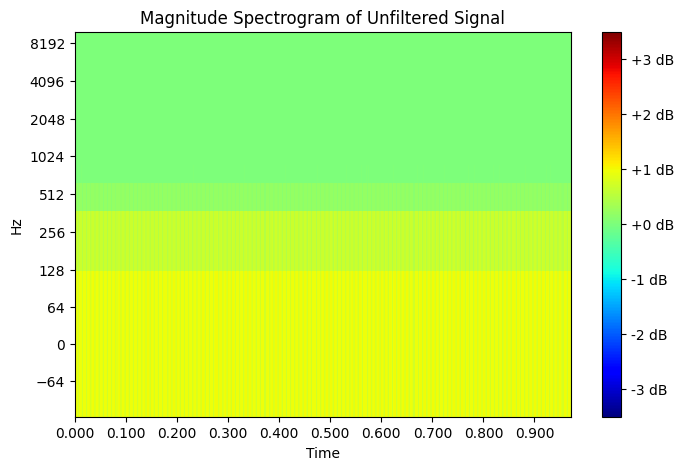

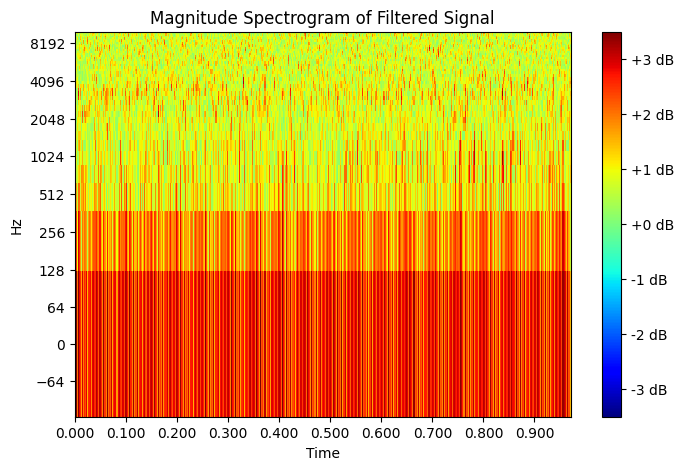

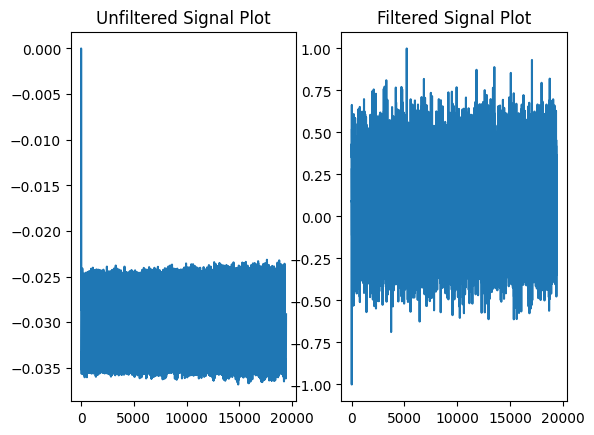

Converted and saved audio segment 4/18 to Documents.
Progress: 0.005150126178091363% done after 0.019598960876464844 seconds.
Progress: 1.004274604727816% done after 4.50692892074585 seconds.
Progress: 2.0033990832775403% done after 8.906898975372314 seconds.
Progress: 3.0025235618272648% done after 13.408272981643677 seconds.
Progress: 4.001648040376989% done after 17.856766939163208 seconds.
Progress: 5.000772518926714% done after 22.25243091583252 seconds.
Progress: 5.999896997476438% done after 26.683165073394775 seconds.
Progress: 6.999021476026162% done after 31.12989902496338 seconds.
Progress: 7.998145954575888% done after 35.59213995933533 seconds.
Progress: 8.997270433125612% done after 40.04312300682068 seconds.
Progress: 9.996394911675337% done after 44.49922204017639 seconds.
Progress: 10.99551939022506% done after 49.10979199409485 seconds.
Progress: 11.994643868774785% done after 53.53827786445618 seconds.
Progress: 12.993768347324512% done after 58.01498889923096 second

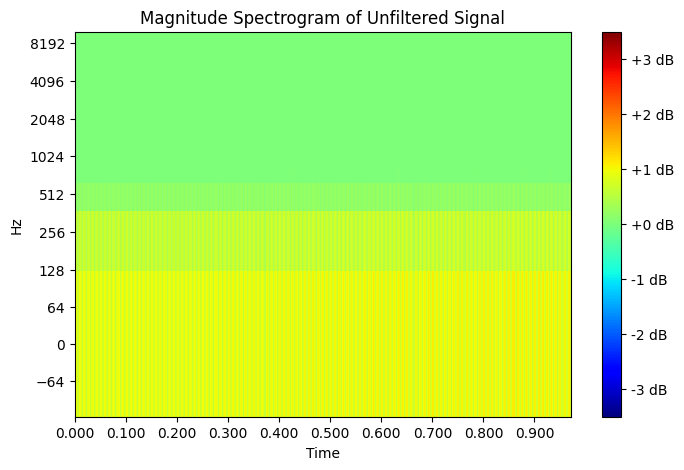

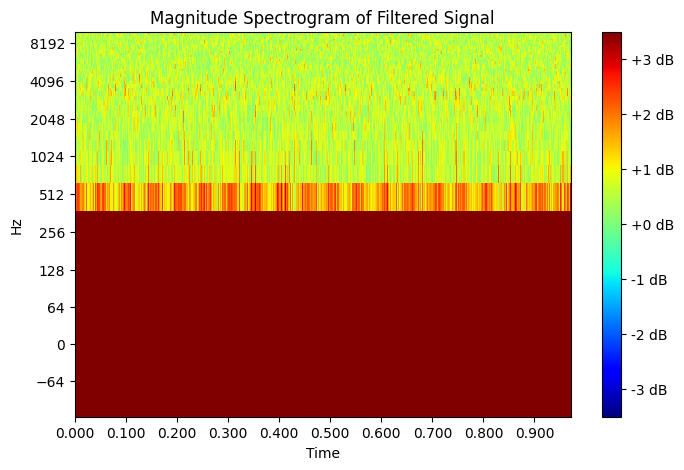

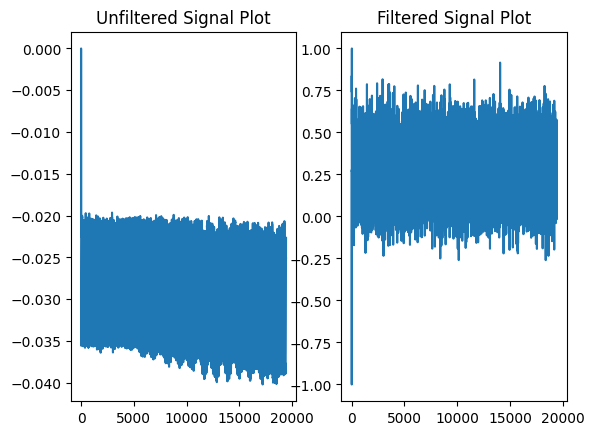

Converted and saved audio segment 5/18 to Documents.
Progress: 0.005150126178091363% done after 0.020051956176757812 seconds.
Progress: 1.004274604727816% done after 4.54688572883606 seconds.
Progress: 2.0033990832775403% done after 9.085456848144531 seconds.
Progress: 3.0025235618272648% done after 13.574012756347656 seconds.
Progress: 4.001648040376989% done after 18.075927019119263 seconds.
Progress: 5.000772518926714% done after 22.64993381500244 seconds.
Progress: 5.999896997476438% done after 27.231812715530396 seconds.
Progress: 6.999021476026162% done after 31.827918767929077 seconds.
Progress: 7.998145954575888% done after 36.375020027160645 seconds.
Progress: 8.997270433125612% done after 40.9351806640625 seconds.
Progress: 9.996394911675337% done after 45.466954946517944 seconds.
Progress: 10.99551939022506% done after 49.98364067077637 seconds.
Progress: 11.994643868774785% done after 54.53917479515076 seconds.
Progress: 12.993768347324512% done after 58.98737096786499 seco

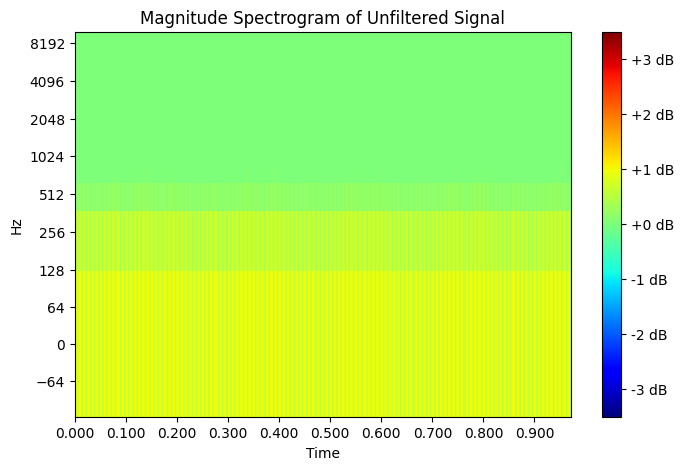

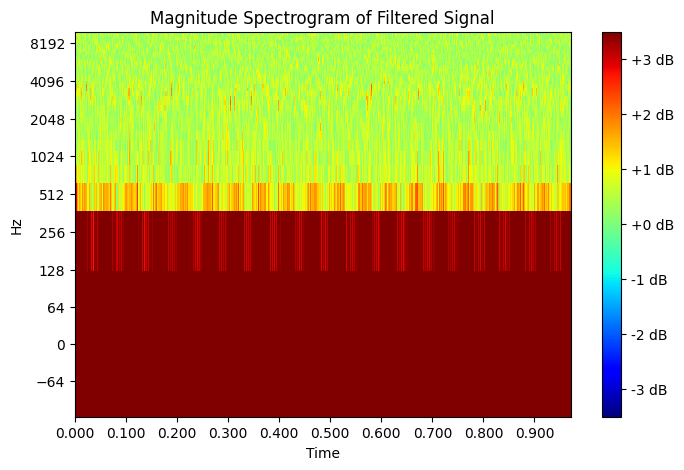

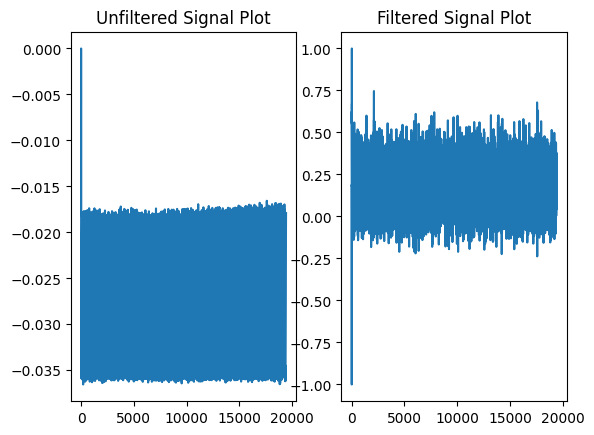

Converted and saved audio segment 6/18 to Documents.
Progress: 0.005150126178091363% done after 0.0189969539642334 seconds.
Progress: 1.004274604727816% done after 4.523967266082764 seconds.
Progress: 2.0033990832775403% done after 8.98290729522705 seconds.
Progress: 3.0025235618272648% done after 13.40932297706604 seconds.
Progress: 4.001648040376989% done after 17.972063302993774 seconds.
Progress: 5.000772518926714% done after 22.452455282211304 seconds.
Progress: 5.999896997476438% done after 26.927658319473267 seconds.
Progress: 6.999021476026162% done after 31.454331159591675 seconds.
Progress: 7.998145954575888% done after 36.00968599319458 seconds.
Progress: 8.997270433125612% done after 40.46583914756775 seconds.
Progress: 9.996394911675337% done after 45.08645033836365 seconds.
Progress: 10.99551939022506% done after 49.57899713516235 seconds.
Progress: 11.994643868774785% done after 54.14753031730652 seconds.
Progress: 12.993768347324512% done after 58.7144980430603 seconds.

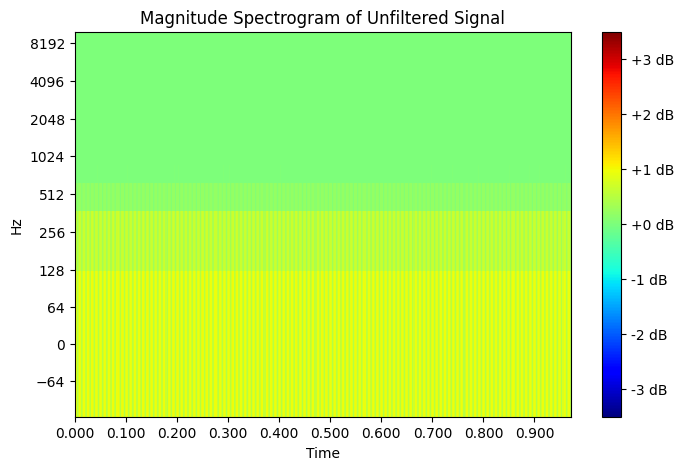

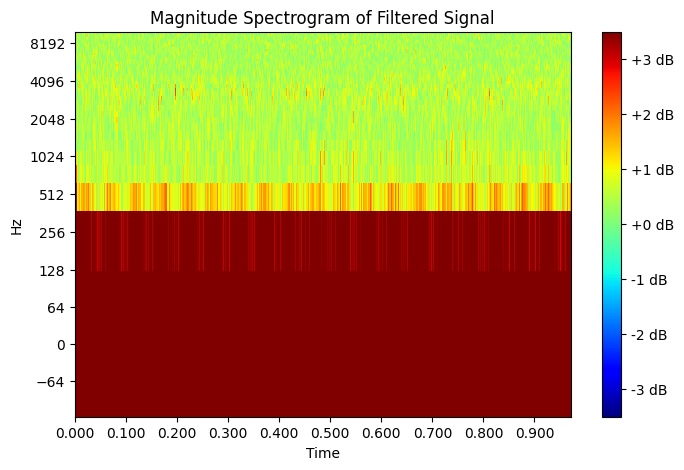

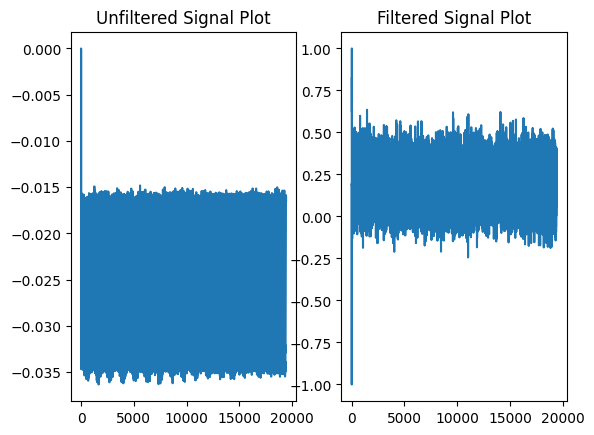

Converted and saved audio segment 7/18 to Documents.
Progress: 0.005150126178091363% done after 0.02007913589477539 seconds.
Progress: 1.004274604727816% done after 4.581786870956421 seconds.
Progress: 2.0033990832775403% done after 9.075891017913818 seconds.
Progress: 3.0025235618272648% done after 13.586755990982056 seconds.
Progress: 4.001648040376989% done after 18.02706789970398 seconds.
Progress: 5.000772518926714% done after 22.438564777374268 seconds.
Progress: 5.999896997476438% done after 26.925007104873657 seconds.
Progress: 6.999021476026162% done after 31.30520796775818 seconds.
Progress: 7.998145954575888% done after 35.79886794090271 seconds.
Progress: 8.997270433125612% done after 40.24794602394104 seconds.
Progress: 9.996394911675337% done after 44.699236154556274 seconds.
Progress: 10.99551939022506% done after 49.04452204704285 seconds.
Progress: 11.994643868774785% done after 53.5821270942688 seconds.
Progress: 12.993768347324512% done after 58.077943086624146 secon

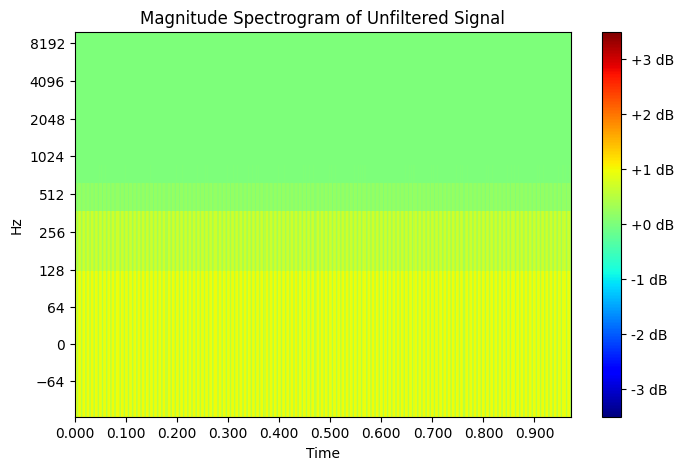

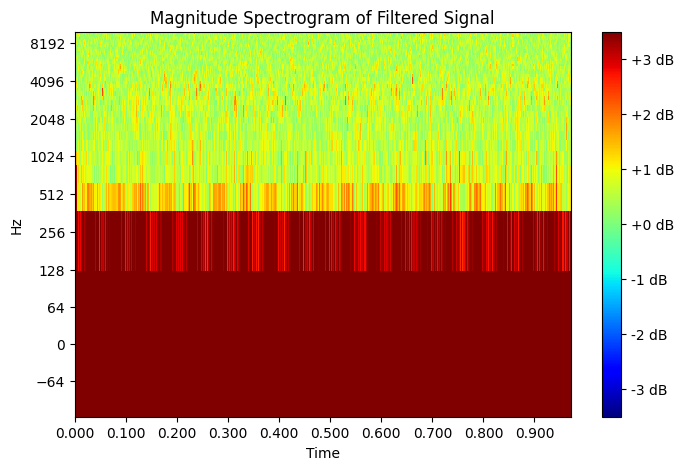

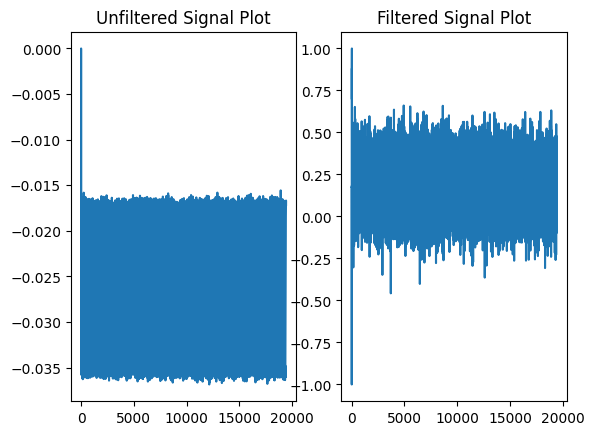

Converted and saved audio segment 8/18 to Documents.
Progress: 0.005150126178091363% done after 0.020936012268066406 seconds.
Progress: 1.004274604727816% done after 4.574522972106934 seconds.
Progress: 2.0033990832775403% done after 9.266602993011475 seconds.
Progress: 3.0025235618272648% done after 13.89096212387085 seconds.
Progress: 4.001648040376989% done after 18.462623119354248 seconds.
Progress: 5.000772518926714% done after 23.227572202682495 seconds.
Progress: 5.999896997476438% done after 27.92154884338379 seconds.
Progress: 6.999021476026162% done after 32.64303994178772 seconds.
Progress: 7.998145954575888% done after 37.2592339515686 seconds.
Progress: 8.997270433125612% done after 41.85578989982605 seconds.
Progress: 9.996394911675337% done after 46.47225999832153 seconds.
Progress: 10.99551939022506% done after 51.098593950271606 seconds.
Progress: 11.994643868774785% done after 55.78765106201172 seconds.
Progress: 12.993768347324512% done after 60.55529522895813 second

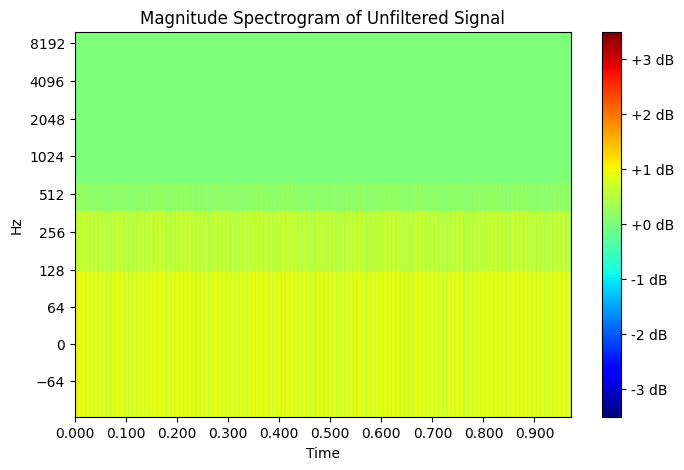

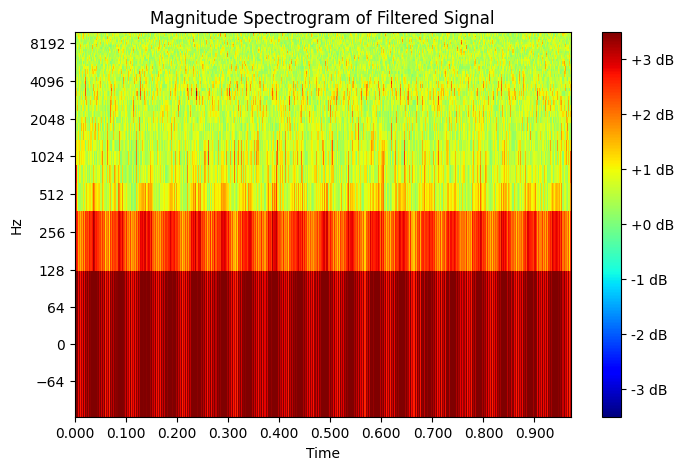

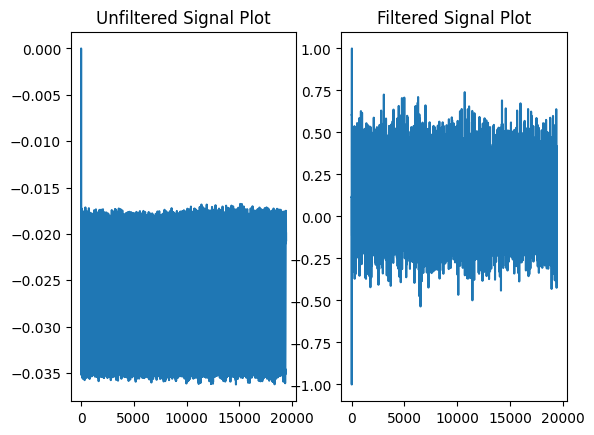

Converted and saved audio segment 9/18 to Documents.
Progress: 0.005150126178091363% done after 0.02043604850769043 seconds.
Progress: 1.004274604727816% done after 4.62462592124939 seconds.
Progress: 2.0033990832775403% done after 9.21476697921753 seconds.
Progress: 3.0025235618272648% done after 13.894721031188965 seconds.
Progress: 4.001648040376989% done after 18.458060026168823 seconds.
Progress: 5.000772518926714% done after 23.049474000930786 seconds.
Progress: 5.999896997476438% done after 27.62837314605713 seconds.
Progress: 6.999021476026162% done after 32.13448095321655 seconds.
Progress: 7.998145954575888% done after 36.72187805175781 seconds.
Progress: 8.997270433125612% done after 41.28075814247131 seconds.
Progress: 9.996394911675337% done after 45.97674202919006 seconds.
Progress: 10.99551939022506% done after 50.53303003311157 seconds.
Progress: 11.994643868774785% done after 55.06924390792847 seconds.
Progress: 12.993768347324512% done after 59.90346717834473 seconds.

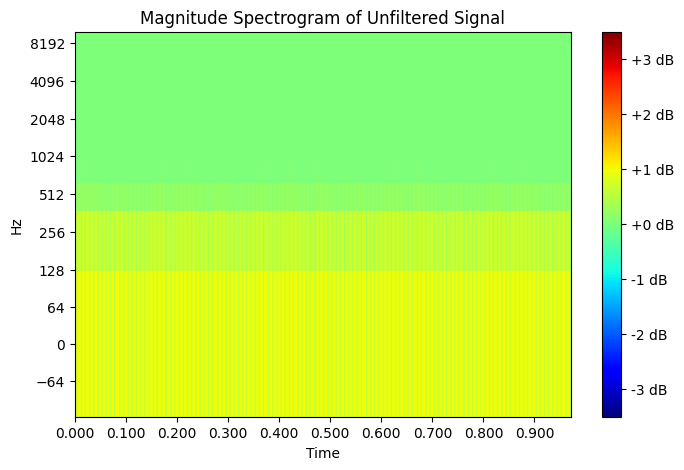

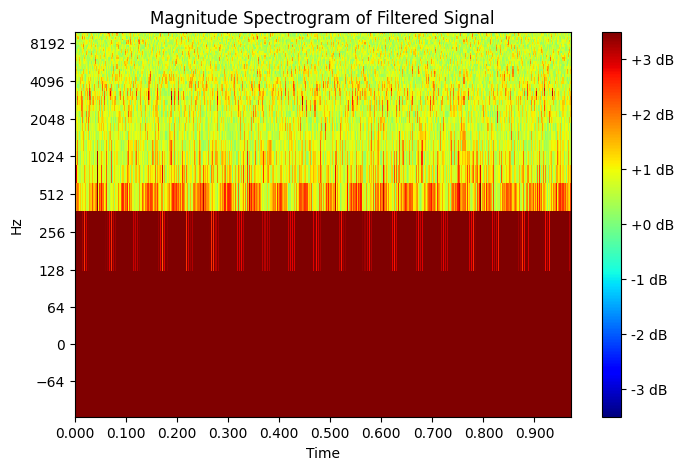

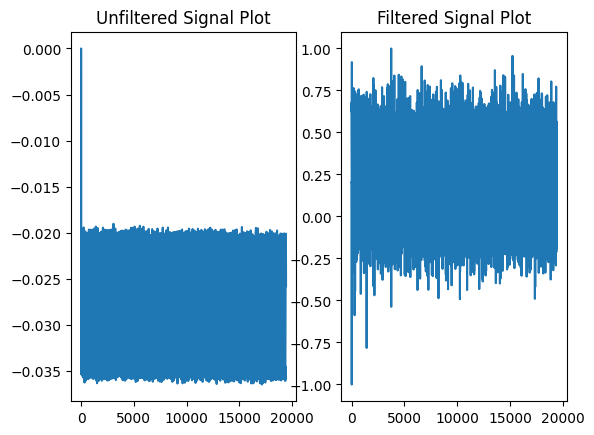

Converted and saved audio segment 10/18 to Documents.
Progress: 0.005150126178091363% done after 0.020702838897705078 seconds.
Progress: 1.004274604727816% done after 4.669475078582764 seconds.
Progress: 2.0033990832775403% done after 9.363716125488281 seconds.
Progress: 3.0025235618272648% done after 14.262832880020142 seconds.
Progress: 4.001648040376989% done after 19.298753023147583 seconds.
Progress: 5.000772518926714% done after 24.110673904418945 seconds.
Progress: 5.999896997476438% done after 28.981209993362427 seconds.
Progress: 6.999021476026162% done after 33.88786292076111 seconds.
Progress: 7.998145954575888% done after 38.70983695983887 seconds.
Progress: 8.997270433125612% done after 43.4550199508667 seconds.
Progress: 9.996394911675337% done after 48.17636299133301 seconds.
Progress: 10.99551939022506% done after 52.991661071777344 seconds.
Progress: 11.994643868774785% done after 57.89678478240967 seconds.
Progress: 12.993768347324512% done after 62.67094707489014 sec

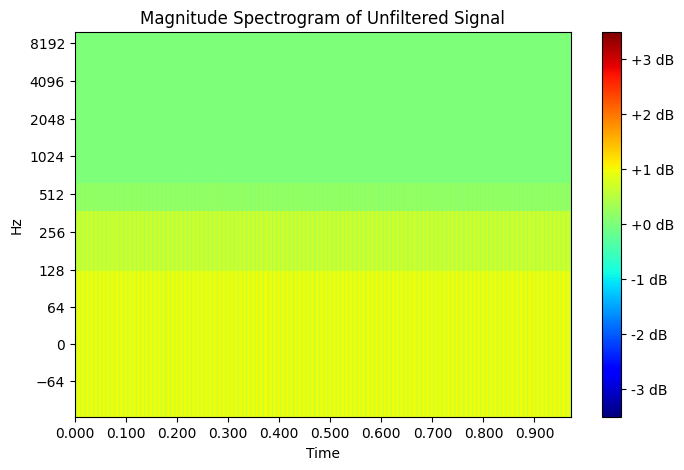

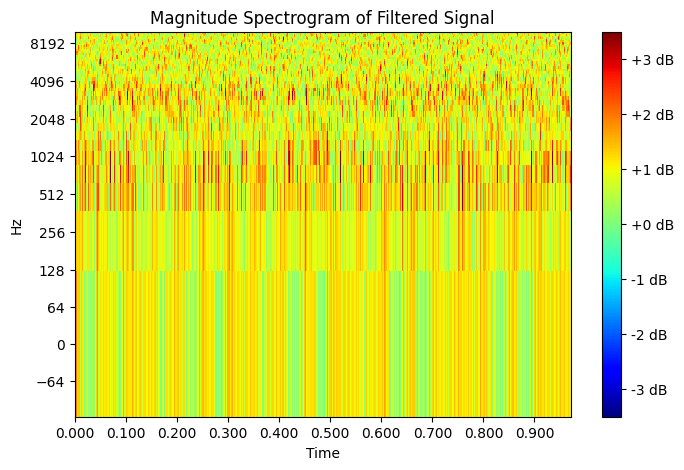

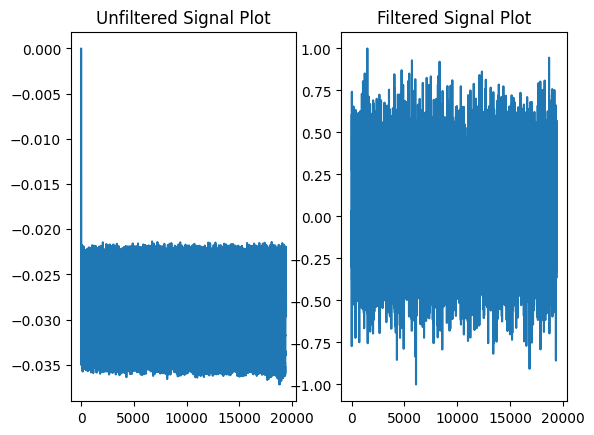

Converted and saved audio segment 11/18 to Documents.
Progress: 0.005150126178091363% done after 0.019115924835205078 seconds.
Progress: 1.004274604727816% done after 4.480087995529175 seconds.
Progress: 2.0033990832775403% done after 8.985343933105469 seconds.
Progress: 3.0025235618272648% done after 13.369614124298096 seconds.
Progress: 4.001648040376989% done after 17.792469263076782 seconds.
Progress: 5.000772518926714% done after 22.1774001121521 seconds.
Progress: 5.999896997476438% done after 26.580474138259888 seconds.
Progress: 6.999021476026162% done after 30.988790035247803 seconds.
Progress: 7.998145954575888% done after 35.42638111114502 seconds.
Progress: 8.997270433125612% done after 39.90915608406067 seconds.
Progress: 9.996394911675337% done after 44.365724086761475 seconds.
Progress: 10.99551939022506% done after 48.71778702735901 seconds.
Progress: 11.994643868774785% done after 53.22245907783508 seconds.
Progress: 12.993768347324512% done after 57.669114112854004 se

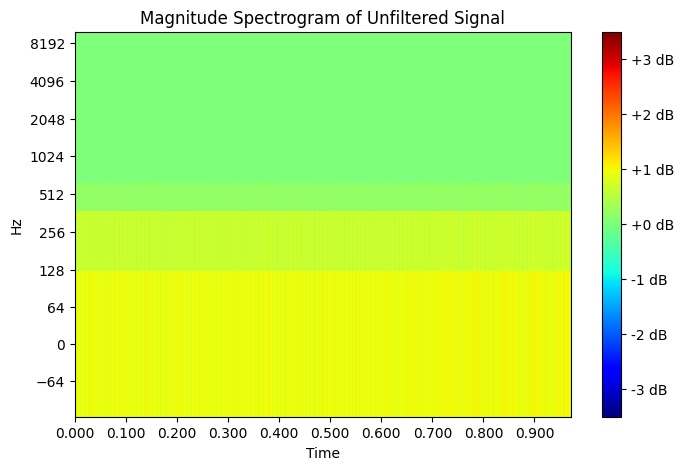

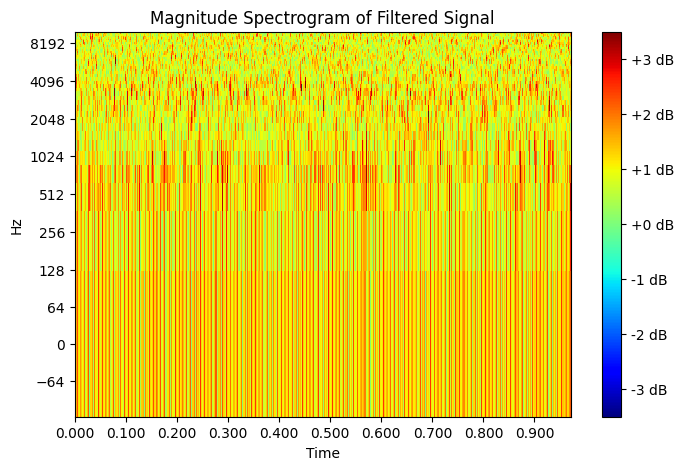

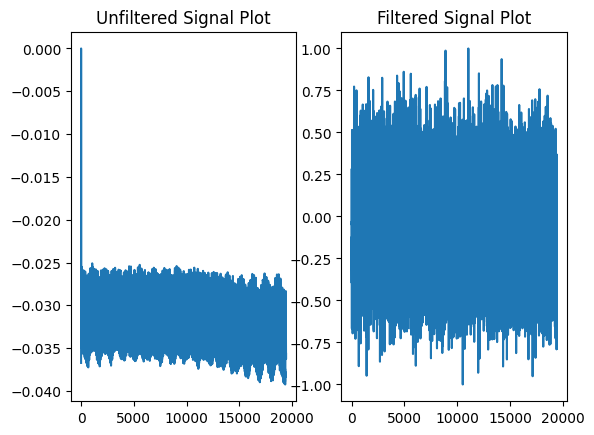

Converted and saved audio segment 12/18 to Documents.
Progress: 0.005150126178091363% done after 0.019376754760742188 seconds.
Progress: 1.004274604727816% done after 4.452322721481323 seconds.
Progress: 2.0033990832775403% done after 8.862348794937134 seconds.
Progress: 3.0025235618272648% done after 13.305686950683594 seconds.
Progress: 4.001648040376989% done after 17.61844563484192 seconds.
Progress: 5.000772518926714% done after 22.155558824539185 seconds.
Progress: 5.999896997476438% done after 26.59669780731201 seconds.
Progress: 6.999021476026162% done after 31.11885166168213 seconds.
Progress: 7.998145954575888% done after 35.52667284011841 seconds.
Progress: 8.997270433125612% done after 39.91522192955017 seconds.
Progress: 9.996394911675337% done after 44.42582583427429 seconds.
Progress: 10.99551939022506% done after 48.918866872787476 seconds.
Progress: 11.994643868774785% done after 53.39100170135498 seconds.
Progress: 12.993768347324512% done after 57.80475378036499 seco

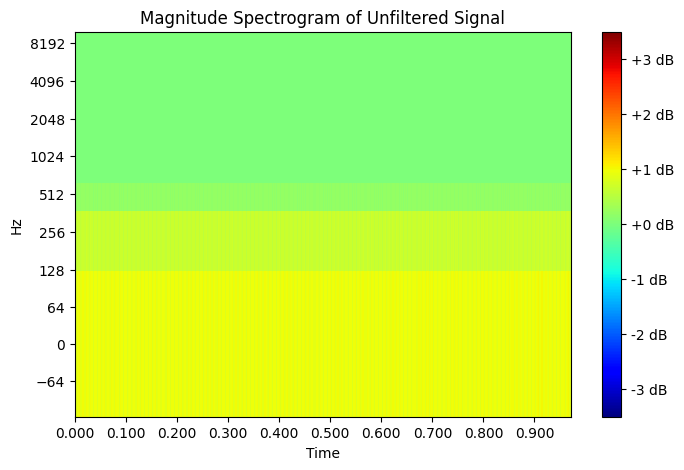

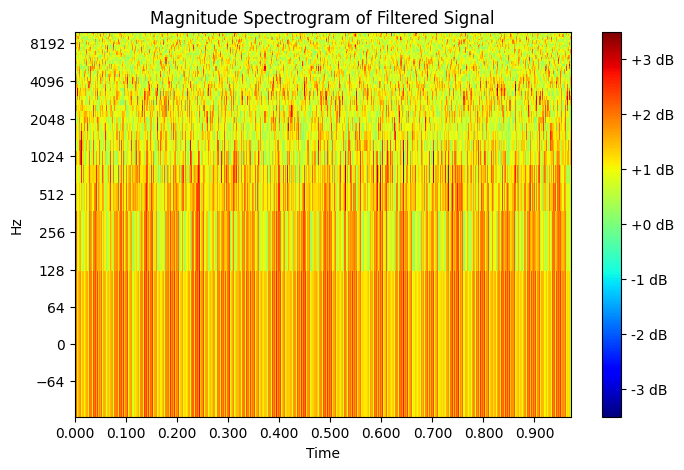

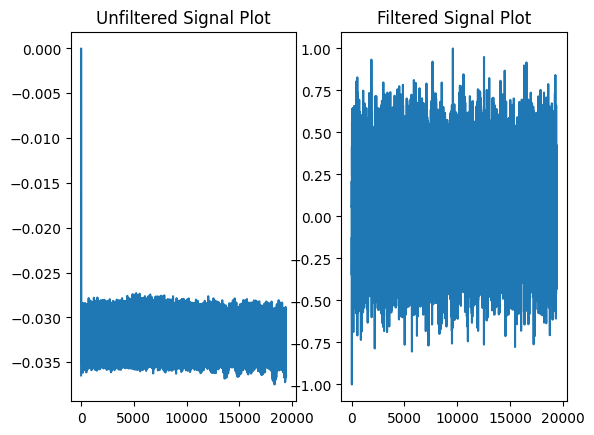

Converted and saved audio segment 13/18 to Documents.
Progress: 0.005150126178091363% done after 0.021210908889770508 seconds.
Progress: 1.004274604727816% done after 4.749969959259033 seconds.
Progress: 2.0033990832775403% done after 9.335864782333374 seconds.
Progress: 3.0025235618272648% done after 13.841678857803345 seconds.
Progress: 4.001648040376989% done after 18.390006065368652 seconds.
Progress: 5.000772518926714% done after 22.967119932174683 seconds.
Progress: 5.999896997476438% done after 27.54681086540222 seconds.
Progress: 6.999021476026162% done after 32.10442495346069 seconds.
Progress: 7.998145954575888% done after 36.59293794631958 seconds.
Progress: 8.997270433125612% done after 41.190523862838745 seconds.
Progress: 9.996394911675337% done after 45.83989095687866 seconds.
Progress: 10.99551939022506% done after 50.3397319316864 seconds.
Progress: 11.994643868774785% done after 54.90778613090515 seconds.
Progress: 12.993768347324512% done after 59.31971216201782 seco

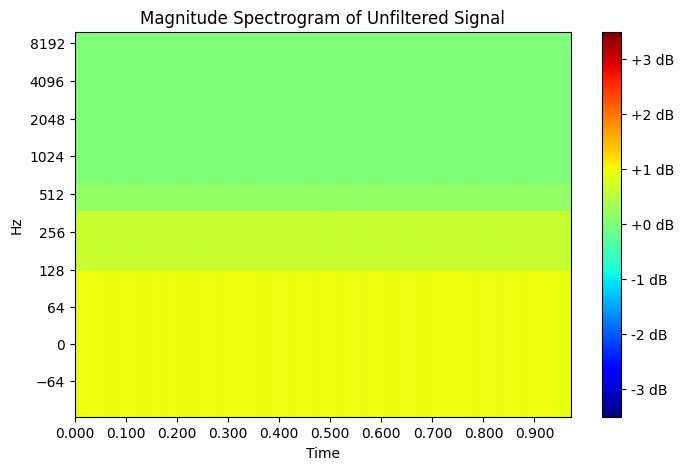

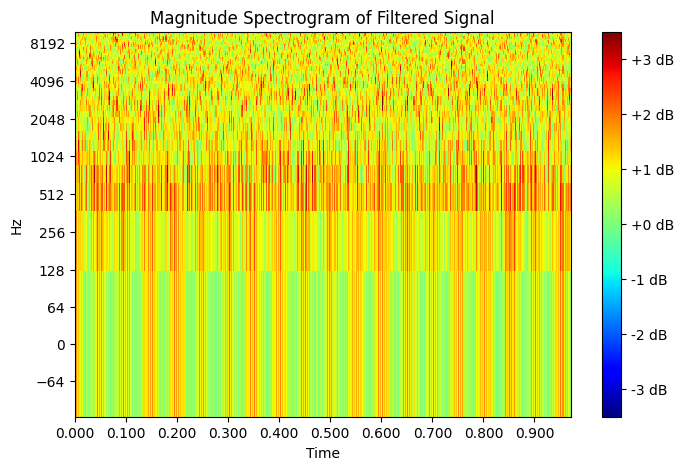

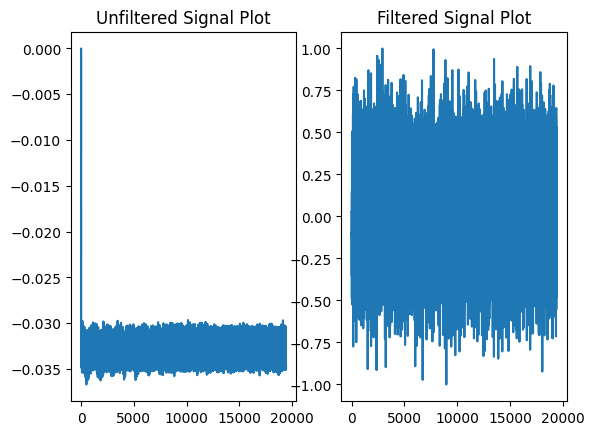

Converted and saved audio segment 14/18 to Documents.
Progress: 0.005150126178091363% done after 0.019500017166137695 seconds.
Progress: 1.004274604727816% done after 4.5027756690979 seconds.
Progress: 2.0033990832775403% done after 8.896763801574707 seconds.
Progress: 3.0025235618272648% done after 13.236887693405151 seconds.
Progress: 4.001648040376989% done after 17.708043813705444 seconds.
Progress: 5.000772518926714% done after 22.31590175628662 seconds.
Progress: 5.999896997476438% done after 26.755330801010132 seconds.
Progress: 6.999021476026162% done after 31.144258737564087 seconds.
Progress: 7.998145954575888% done after 35.78529477119446 seconds.
Progress: 8.997270433125612% done after 40.2439067363739 seconds.
Progress: 9.996394911675337% done after 44.63032293319702 seconds.
Progress: 10.99551939022506% done after 49.039050817489624 seconds.
Progress: 11.994643868774785% done after 53.42158079147339 seconds.
Progress: 12.993768347324512% done after 57.859198808670044 seco

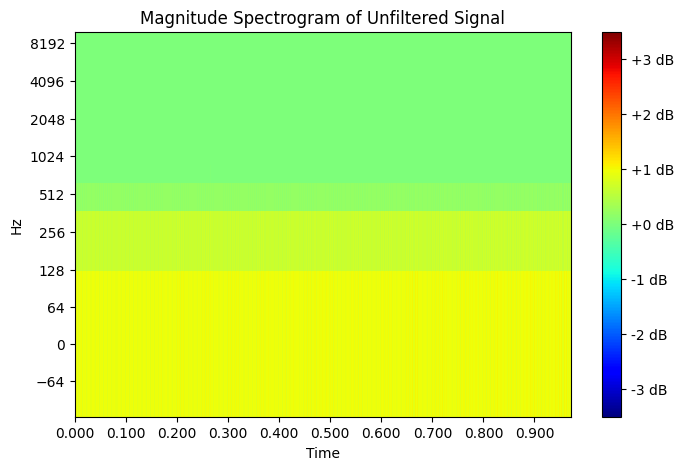

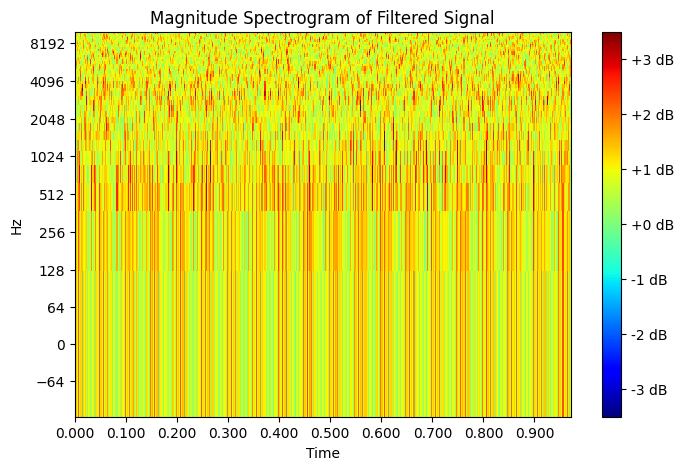

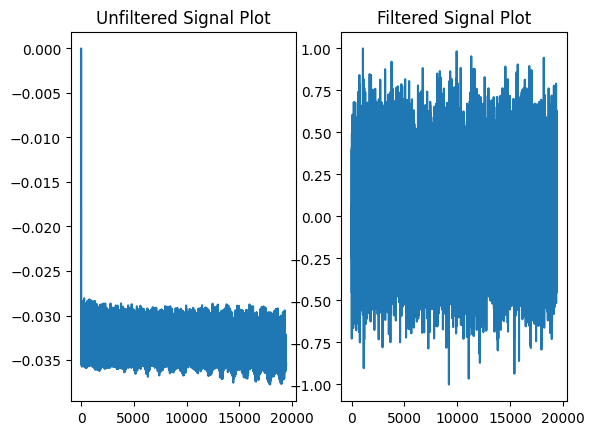

Converted and saved audio segment 15/18 to Documents.
Progress: 0.005150126178091363% done after 0.020061254501342773 seconds.
Progress: 1.004274604727816% done after 4.476254940032959 seconds.
Progress: 2.0033990832775403% done after 9.124061822891235 seconds.
Progress: 3.0025235618272648% done after 13.669564247131348 seconds.
Progress: 4.001648040376989% done after 18.09989595413208 seconds.
Progress: 5.000772518926714% done after 22.657735109329224 seconds.
Progress: 5.999896997476438% done after 27.11811089515686 seconds.
Progress: 6.999021476026162% done after 31.64756202697754 seconds.
Progress: 7.998145954575888% done after 36.258639097213745 seconds.
Progress: 8.997270433125612% done after 40.81147909164429 seconds.
Progress: 9.996394911675337% done after 45.3707492351532 seconds.
Progress: 10.99551939022506% done after 49.92692804336548 seconds.
Progress: 11.994643868774785% done after 54.47290325164795 seconds.
Progress: 12.993768347324512% done after 59.00219798088074 secon

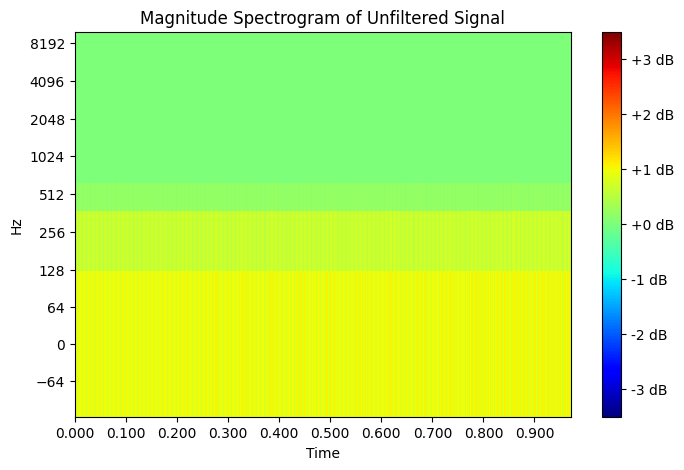

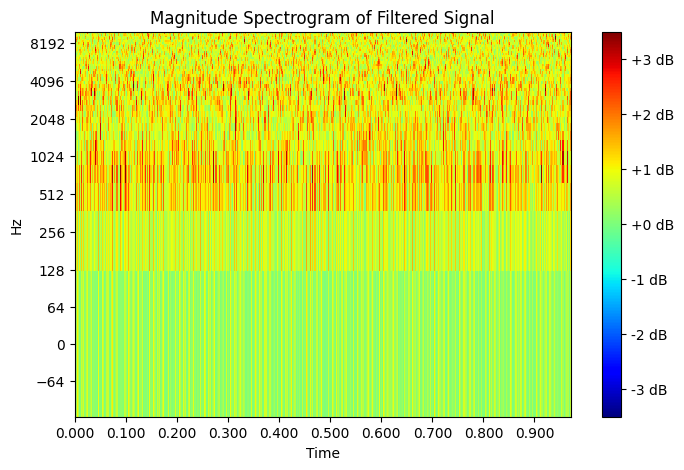

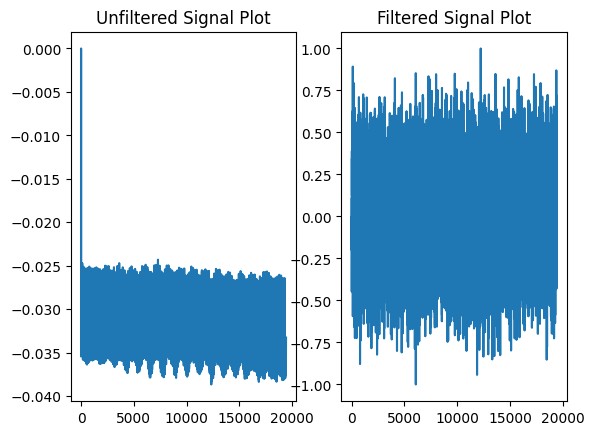

Converted and saved audio segment 16/18 to Documents.
Progress: 0.005150126178091363% done after 0.020720958709716797 seconds.
Progress: 1.004274604727816% done after 4.579486846923828 seconds.
Progress: 2.0033990832775403% done after 9.108312129974365 seconds.
Progress: 3.0025235618272648% done after 13.760280132293701 seconds.
Progress: 4.001648040376989% done after 18.316694021224976 seconds.
Progress: 5.000772518926714% done after 22.838217973709106 seconds.
Progress: 5.999896997476438% done after 27.44332480430603 seconds.
Progress: 6.999021476026162% done after 32.11725997924805 seconds.
Progress: 7.998145954575888% done after 36.68630385398865 seconds.
Progress: 8.997270433125612% done after 41.135313987731934 seconds.
Progress: 9.996394911675337% done after 45.54113006591797 seconds.
Progress: 10.99551939022506% done after 50.01347208023071 seconds.
Progress: 11.994643868774785% done after 54.48962092399597 seconds.
Progress: 12.993768347324512% done after 58.91652774810791 sec

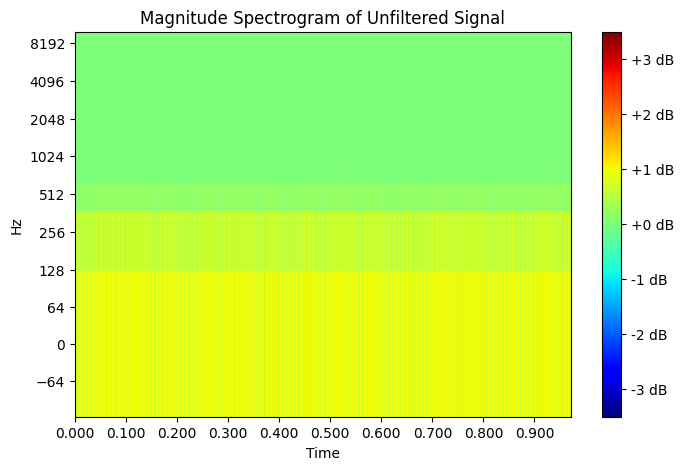

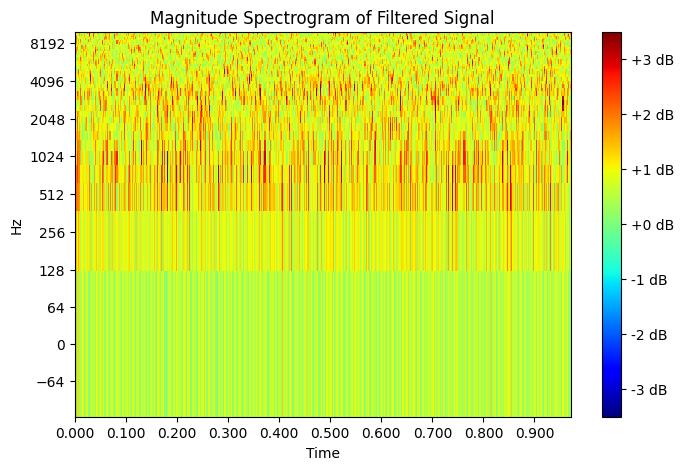

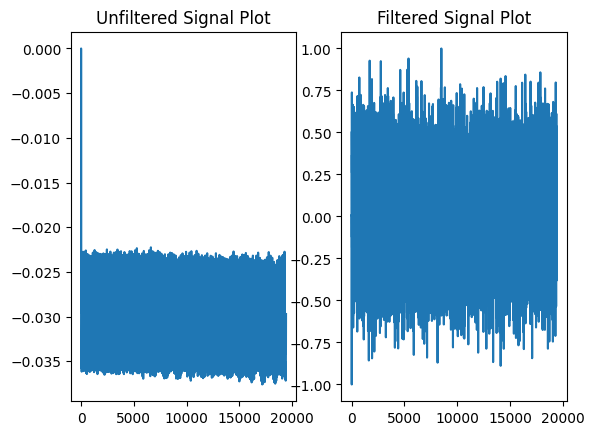

Converted and saved audio segment 17/18 to Documents.
Progress: 0.01935733643050716% done after 0.021641969680786133 seconds.
Progress: 1.0065814943863725% done after 1.1398460865020752 seconds.
Progress: 1.9938056523422378% done after 2.3387131690979004 seconds.
Progress: 2.9810298102981028% done after 3.5441253185272217 seconds.
Progress: 3.968253968253968% done after 4.729907989501953 seconds.
Progress: 4.955478126209833% done after 5.909779071807861 seconds.
Progress: 5.942702284165699% done after 7.0773890018463135 seconds.
Progress: 6.929926442121564% done after 8.267100095748901 seconds.
Progress: 7.91715060007743% done after 9.414898872375488 seconds.
Progress: 8.904374758033294% done after 10.578489065170288 seconds.
Progress: 9.89159891598916% done after 11.749650239944458 seconds.
Progress: 10.878823073945025% done after 12.946822166442871 seconds.
Progress: 11.866047231900891% done after 14.148224115371704 seconds.
Progress: 12.853271389856754% done after 15.349496126174927

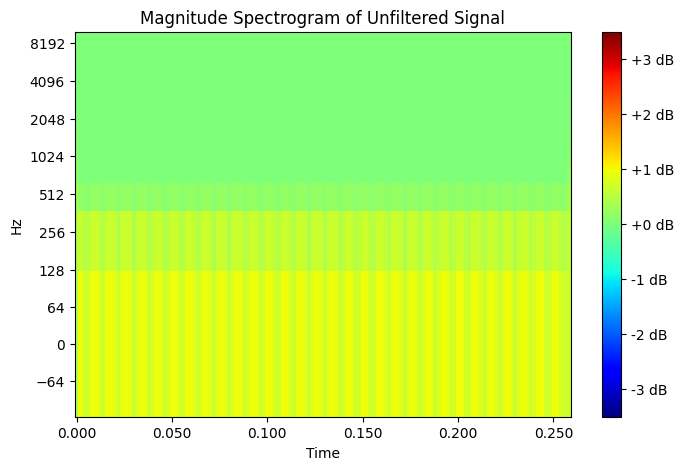

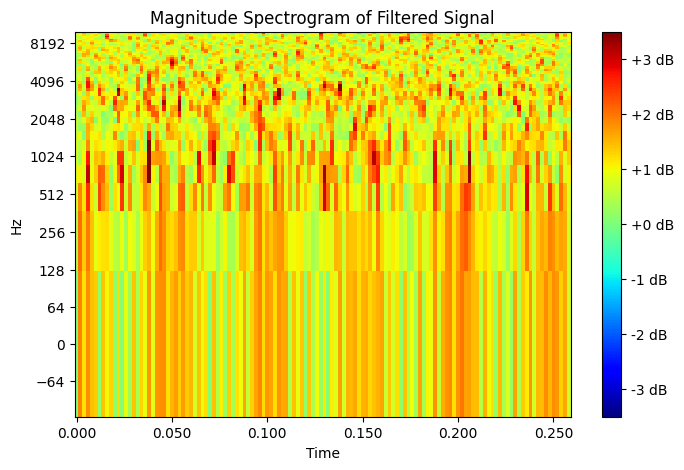

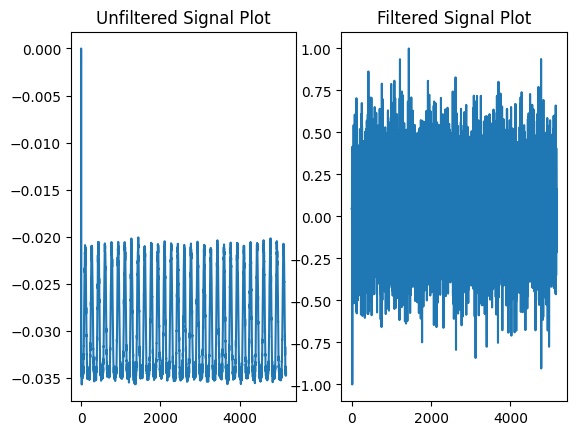

Converted and saved audio segment 18/18 to Documents.
Saved final audio to /Volumes/Omkar 5T/chips3.wav.


In [5]:
pyramid.ebvmSoundfromVideo(save_path, nscales, norientations, framerate)